In [1]:
try:
    __IPYTHON__
    is_notebook = True
    print('Notebook mode')
except NameError:
    is_notebook = False
    print('Script mode')

Notebook mode


# Pip Install

In [2]:
if is_notebook:
    !pip install boto3 astropy sfdmap progressbar2 GPUtil

# Initialization

In [3]:
# Make sure a GPU is available
import GPUtil
print('GPUs:\n{0}'.format('\n'.join(['('+str(i+1)+')\t'+gpu.name for i,gpu in enumerate(GPUtil.getGPUs())])))
import tensorflow as tf
assert tf.config.list_physical_devices('GPU')[0].device_type == 'GPU', 'GPU is not available!'

GPUs:
(1)	NVIDIA A100 80GB PCIe


2023-01-15 12:03:12.582632: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 12:03:12.752331: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-15 12:03:12.789723: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-15 12:03:13.470542: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [4]:
# imports
import pandas as pd
import numpy as np
import os
import sys
import pickle
import boto3
from matplotlib import pyplot as plt
import time

# random seed
seed = 42
np.random.seed(seed)

# local files paths
local_home_dir_path = os.path.expanduser("~")
local_work_dir_path = os.path.join(local_home_dir_path, 'thesis2')
local_code_dir_path = os.path.join(local_work_dir_path , 'code')

# S3 file paths
endpoint_url = 'https://s3-west.nrp-nautilus.io'
bucket_name = 'tau-astro'
prefix = 'almogh'
s3_work_dir_path = os.path.join(prefix, 'thesis2')
s3_data_dir_path = os.path.join(s3_work_dir_path , 'data')
s3_models_dir_path = os.path.join(s3_work_dir_path , 'models')
s3_final_table_csv_path = os.path.join(s3_data_dir_path, 'SDSS_DR16_all.csv')

s3_client = boto3.client("s3", endpoint_url=endpoint_url)

# adding code folder to path
sys.path.insert(1, local_code_dir_path)
from s3 import to_s3_npy, to_s3_pkl, from_s3_npy, from_s3_pkl, to_s3_fig
from s3 import log_s3, s3_save_TF_model
from NN import DistanceLayer, SiameseModel, DistillationDataGenerator

# Prepare Data

In [5]:
model_name = 'NN'

In [6]:
# prepare model paths
s3_model_dir_path = os.path.join(s3_models_dir_path, model_name)
s3_model_train_dir_path = os.path.join(s3_model_dir_path, 'train')
s3_model_test_dir_path = os.path.join(s3_model_dir_path, 'test')
# prepare data paths
s3_data_model_dir_path = os.path.join(s3_data_dir_path, model_name)
s3_data_train_dir_path = os.path.join(s3_data_model_dir_path, 'train')
s3_data_val_dir_path = os.path.join(s3_data_model_dir_path, 'val')
s3_data_test_dir_path = os.path.join(s3_data_dir_path, 'SmallRF', 'test')

In [7]:
# load data
dist_mat_path = os.path.join(s3_models_dir_path, 'SmallRF', 'train', 'dist_mat.npy')
dist_mat = from_s3_npy(s3_client, bucket_name, dist_mat_path)
X_train = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_train_dir_path, 'spec.npy'))
X_val = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_val_dir_path, 'spec.npy'))
X_test = from_s3_npy(s3_client, bucket_name, os.path.join(s3_data_test_dir_path, 'spec.npy'))

loading from uri: s3://tau-astro/almogh/thesis2/models/SmallRF/train/dist_mat.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/train/spec.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/val/spec.npy
loading from uri: s3://tau-astro/almogh/thesis2/data/SmallRF/test/spec.npy


In [8]:
# gs_SmallRF_train = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_dir_path, 'SmallRF', 'train', 'gs.pkl')) # <- This is equal to g_NN
gs = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_model_dir_path, 'gs.pkl'))
gs_train = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_train_dir_path, 'gs.pkl'))
gs_val = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_val_dir_path, 'gs.pkl'))
gs_test = from_s3_pkl(s3_client, bucket_name, os.path.join(s3_data_test_dir_path, 'gs.pkl'))

loading from uri: s3://tau-astro/almogh/thesis2/data/NN/gs.pkl
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/train/gs.pkl
loading from uri: s3://tau-astro/almogh/thesis2/data/NN/val/gs.pkl
loading from uri: s3://tau-astro/almogh/thesis2/data/SmallRF/test/gs.pkl


In [9]:
I_train = np.array([np.where(gs.index == i)[0][0] for i in gs_train.index])
I_val = np.array([np.where(gs.index == i)[0][0] for i in gs_val.index])

In [10]:
dist_mat_train = dist_mat[I_train,:][:,I_train]
dist_mat_val = dist_mat[I_val,:][:,I_val]

In [11]:
if is_notebook:
    print('Notebook mode: running on a tiny slice of the data')
    N_nb = 100
    X_train = X_train[:N_nb,:]
    X_val = X_val[:N_nb,:]
    X_test = X_test[:N_nb,:]
    dist_mat_train = dist_mat_train[:N_nb,:][:,:N_nb]
    dist_mat_val = dist_mat_val[:N_nb,:][:,:N_nb]
    gs_train = gs_train[:N_nb]
    gs_val = gs_val[:N_nb]
    gs_test = gs_test[:N_nb]

Notebook mode: running on a tiny slice of the data


# Creating the model

In [12]:
N_features = X_train.shape[1]

In [13]:
from tensorflow.keras import applications
from tensorflow.keras import activations
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras import utils
from tensorflow.keras import initializers

tf.random.set_seed(seed)

## Embedding Network

In [14]:
hidden_size = 512
encoding_size = 128

# input layer
x_in = layers.Input(shape=(N_features, 1))

# adding the network layers
x = x_in
x = layers.Conv1D(64, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(32, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(16, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(8, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Conv1D(4, 31, activation=None, padding='same', kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.AveragePooling1D( 2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(hidden_size, kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.relu(x)
x = layers.Dense(encoding_size, kernel_initializer=initializers.GlorotUniform(seed=seed))(x)
x = layers.BatchNormalization()(x)
x = activations.tanh(x)
x_out = x

# creating the model
encoding = Model(x_in, x_out)
encoding.summary()

2023-01-15 12:03:30.834040: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 12:03:31.453533: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7929 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe MIG 1g.10gb, pci bus id: 0000:ca:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8400, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 8400, 64)          2048      
                                                                 
 batch_normalization (BatchN  (None, 8400, 64)         256       
 ormalization)                                                   
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 8400, 64)          0         
                                                                 
 average_pooling1d (AverageP  (None, 4200, 64)         0         
 ooling1D)                                                       
                                                                 
 conv1d_1 (Conv1D)           (None, 4200, 32)          63520 

## Siamese Network

In [15]:
first_input = layers.Input(name="first_input", shape=(N_features))
second_input = layers.Input(name="second_input", shape=(N_features))

first_encoding = encoding(first_input)
second_encoding = encoding(second_input)

distance = tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(first_encoding - second_encoding), -1),1e-9))

siamese_network = Model(
    inputs=[first_input, second_input], outputs=distance
)
siamese_network.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 first_input (InputLayer)       [(None, 8400)]       0           []                               
                                                                                                  
 second_input (InputLayer)      [(None, 8400)]       0           []                               
                                                                                                  
 model (Functional)             (None, 128)          694284      ['first_input[0][0]',            
                                                                  'second_input[0][0]']           
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 128)          0           ['model[0][0]',            

## Siamese Model

In [16]:
siamese_model = SiameseModel(siamese_network, dist_loss='L1')
siamese_model.compile(optimizer=optimizers.Adam(0.001))

# Train Model

In [17]:
if is_notebook:
    print('Notebook mode: running short epochs')
    full_epoch = False
else:
    print('Script mode: running full epochs')
    full_epoch = True
train_gen = DistillationDataGenerator(X_train, dist_mat_train, batch_size=128, shuffle=True, seed=seed, snr_range_db=[6,40], full_epoch=full_epoch, norm=True)
val_gen = DistillationDataGenerator(X_val, dist_mat_val, batch_size=128, shuffle=True, seed=seed, snr_range_db=[6,40], full_epoch=full_epoch, norm=True)

Notebook mode: running short epochs
DataGenerator initialized with:
    X shape = 100x8400
    D shape = 100x100
    batch_size = 128
    shuffle = True
    full_epoch = False
    norm = True
    noise = True
    snr_range_db = [6, 40]
DataGenerator initialized with:
    X shape = 100x8400
    D shape = 100x100
    batch_size = 128
    shuffle = True
    full_epoch = False
    norm = True
    noise = True
    snr_range_db = [6, 40]


In [18]:
def plot_loss(fig, ax, e, loss_history, val_loss_history):
    if ax.lines:
        for i,line in enumerate(ax.lines):
            line.set_xdata(e)
            if (i==1):
                line.set_ydata(loss_history)
            else:
                line.set_ydata(val_loss_history)
    else:
        ax.plot(e, loss_history, label='training')
        ax.plot(e, val_loss_history, label='validation')
        ax.legend()
    fig.canvas.draw()

Notebook mode: running for 5 epochs
Training for 5 full epochs, and stopping for saving every 1 full epochs, for a total of 5 stages.
-------------------------------------
epochs 1-1:
-------------------------------------


2023-01-15 12:03:33.500392: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-01-15 12:03:36.013825: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 8s 8s/step - loss: 0.1629 - val_loss: 0.1342


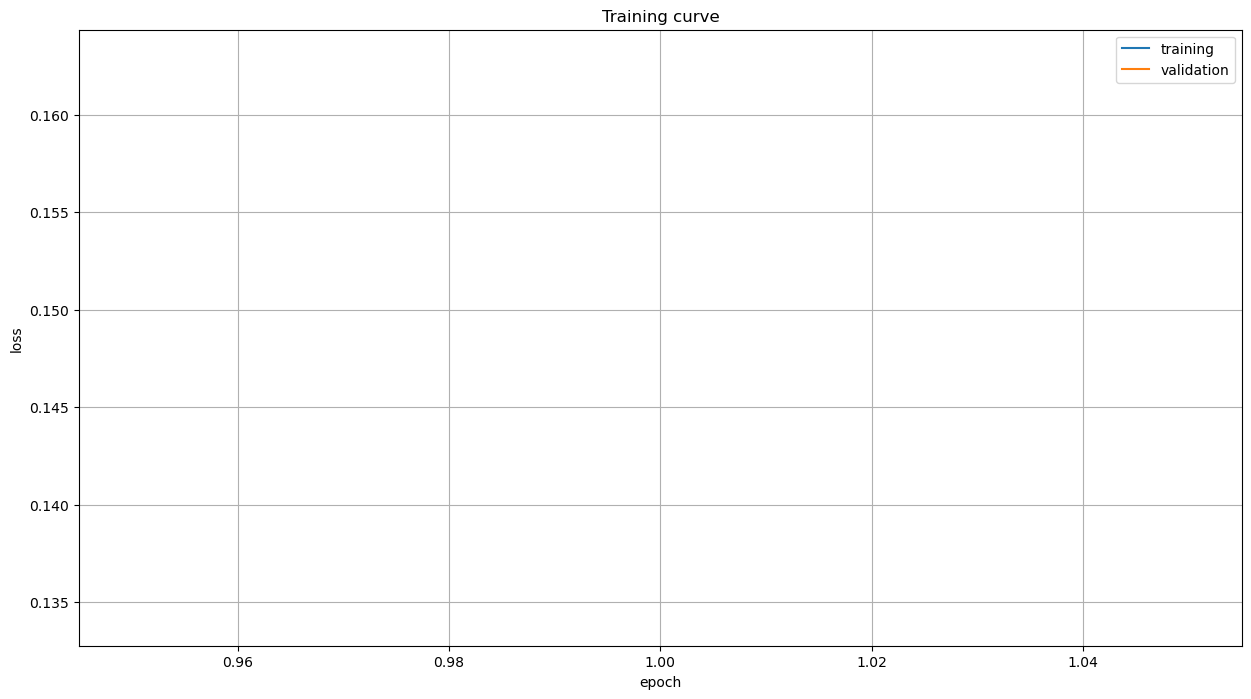

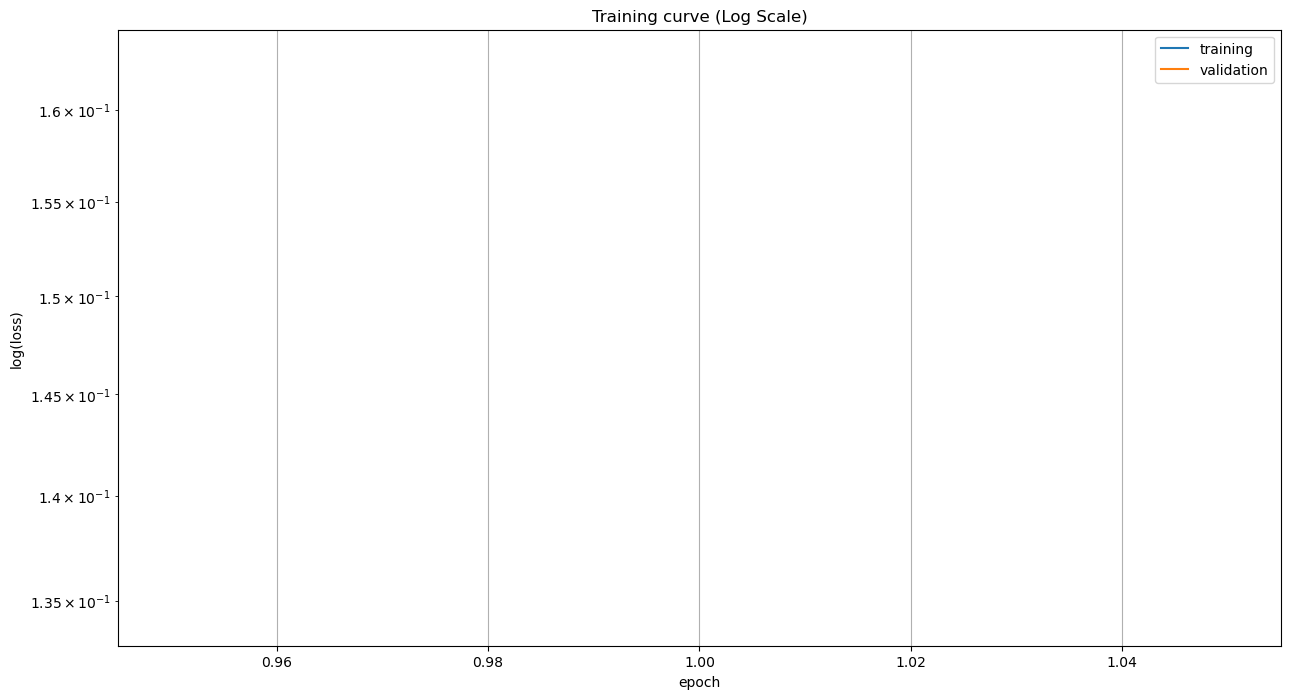

TOTAL TIME = 0.004 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_1_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_1_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_1_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_1_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_1_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpg5yoyzpj/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpg5yoyzpj/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_1_epochs/model
-------------------------------------
epochs 2-2:
-------------------------------------
1/1 [==============================] - 1s 1s/step - loss: 0.1536 - val_loss: 0.1304


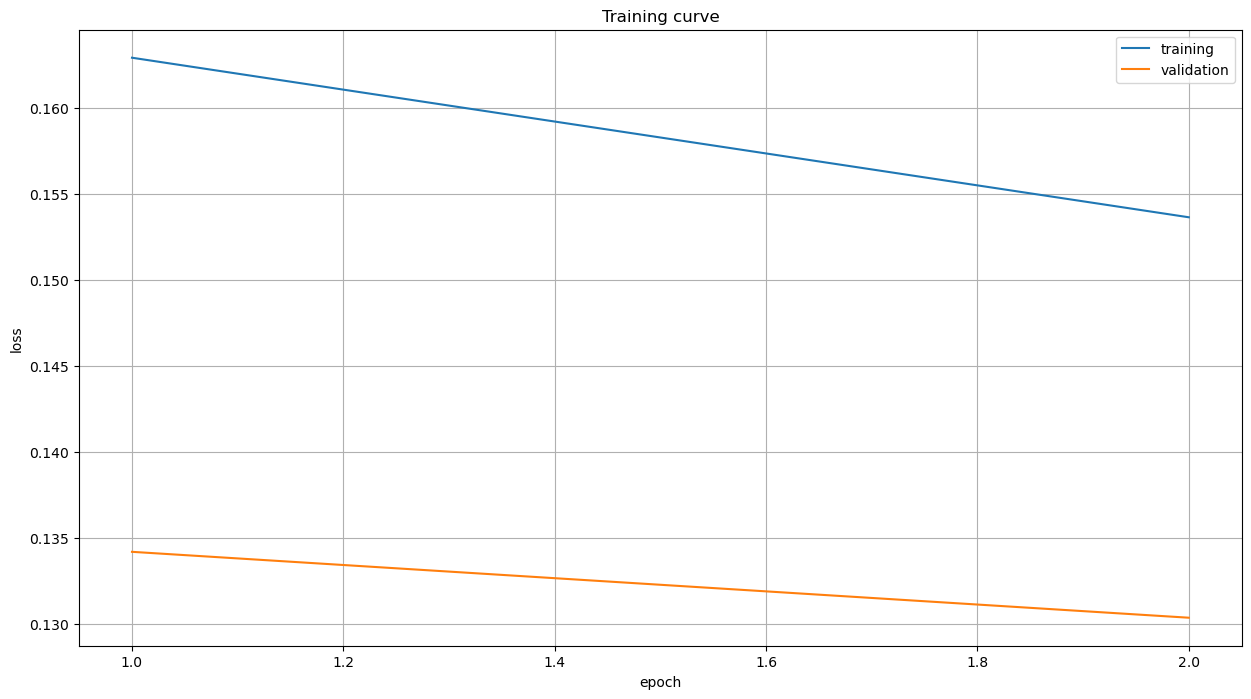

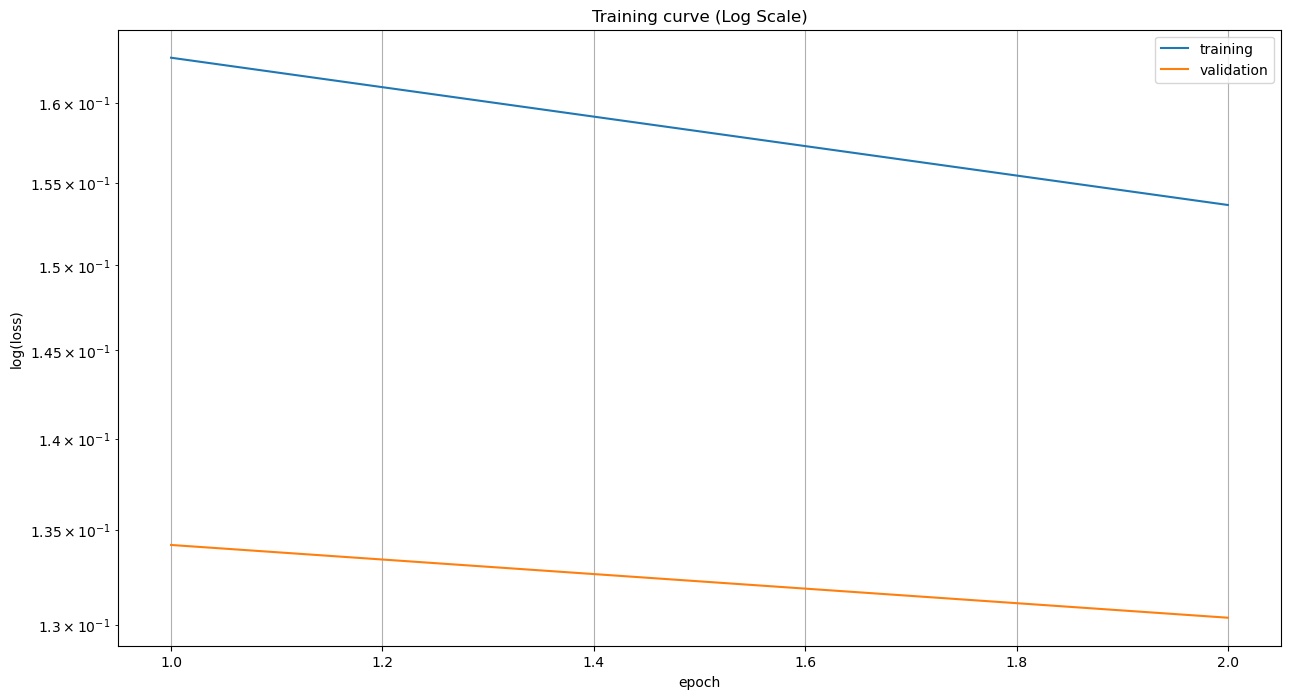

TOTAL TIME = 0.008 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_2_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_2_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_2_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_2_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_2_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmp7nubhqd0/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp7nubhqd0/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_2_epochs/model
-------------------------------------
epochs 3-3:
-------------------------------------
1/1 [==============================] - 1s 1s/step - loss: 0.1280 - val_loss: 0.1176


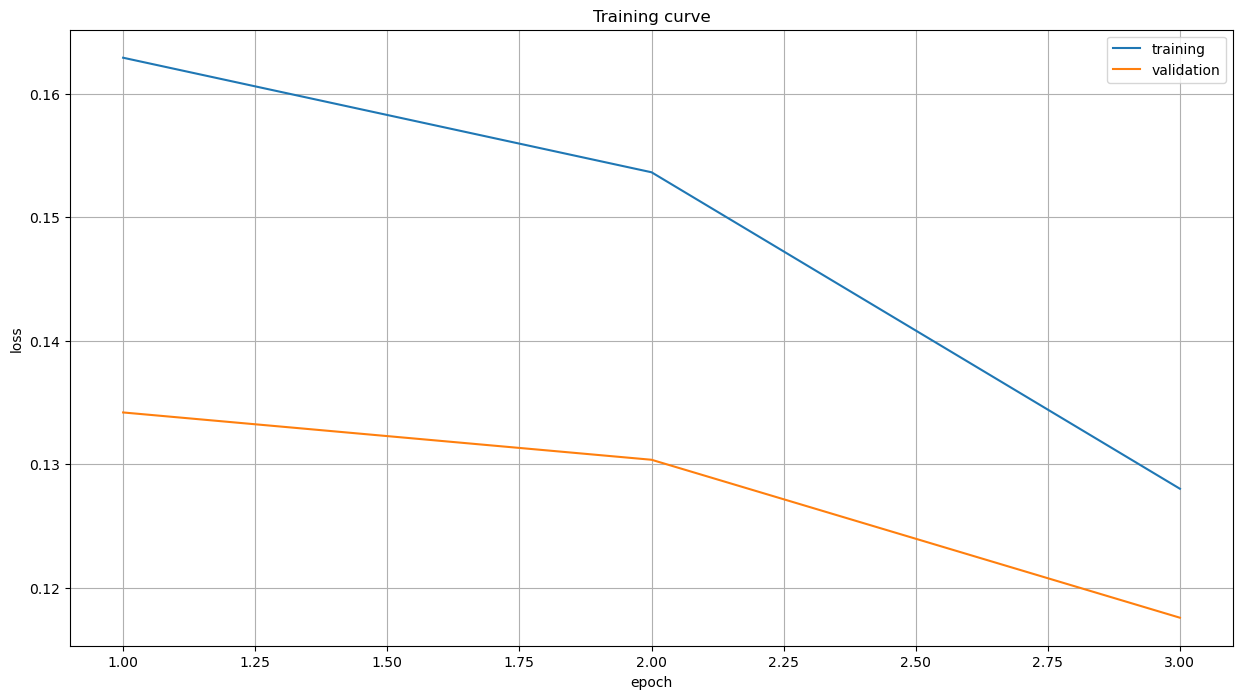

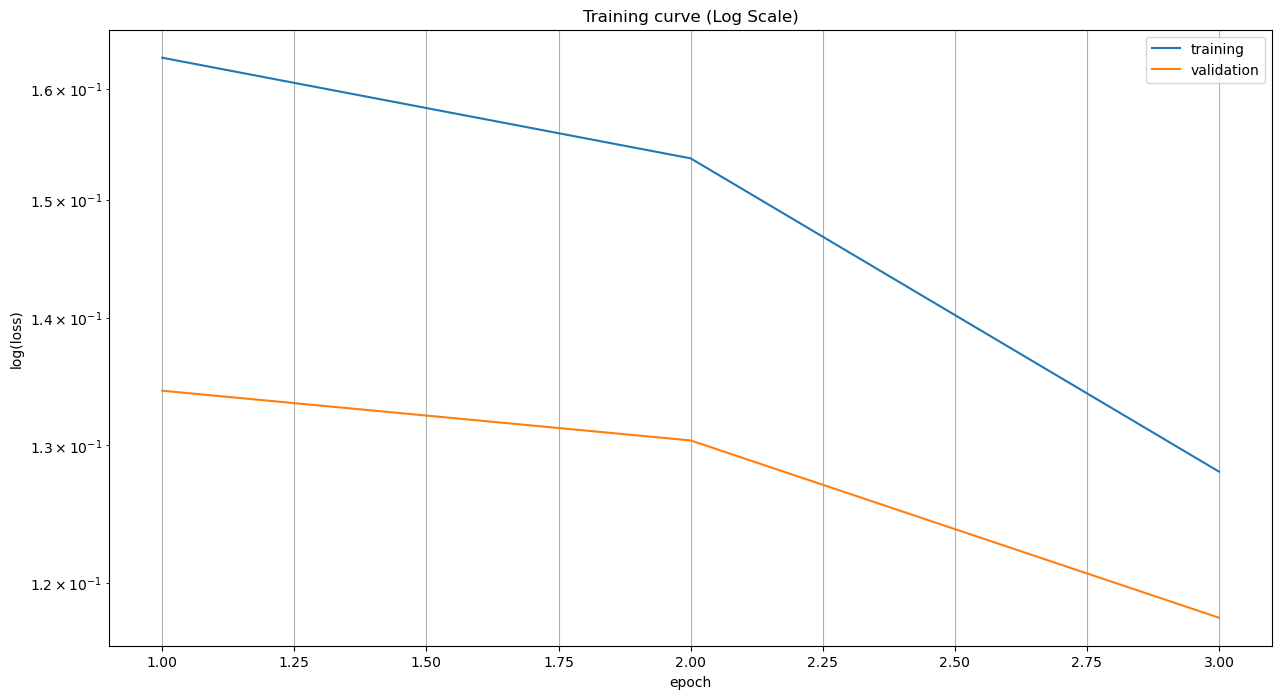

TOTAL TIME = 0.012 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_3_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_3_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_3_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_3_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_3_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmptiua9666/model/assets


INFO:tensorflow:Assets written to: /tmp/tmptiua9666/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_3_epochs/model
-------------------------------------
epochs 4-4:
-------------------------------------
1/1 [==============================] - 1s 1s/step - loss: 0.0972 - val_loss: 0.0788


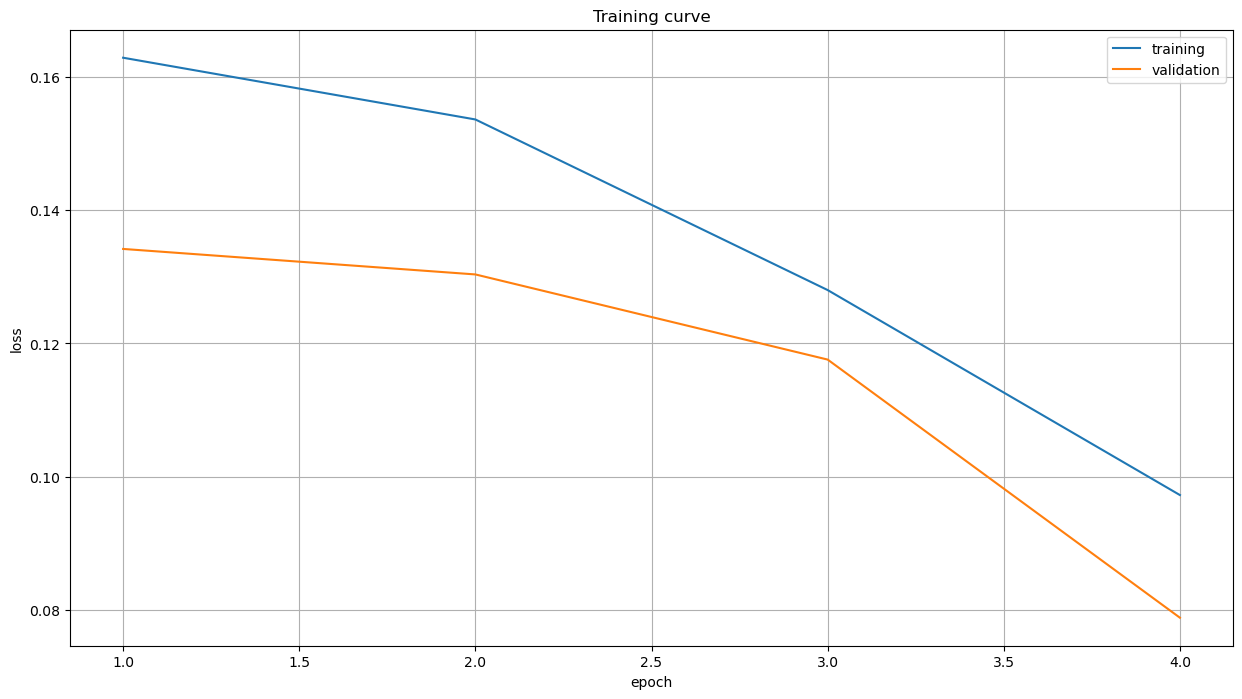

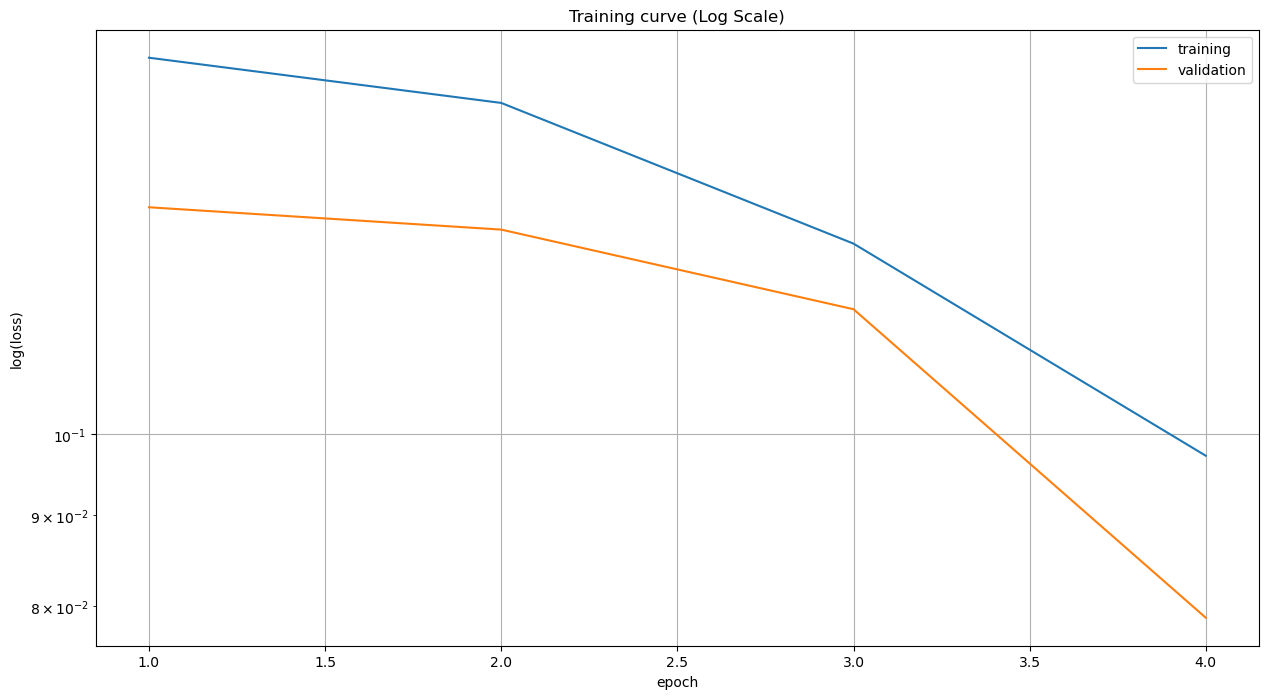

TOTAL TIME = 0.016 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_4_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_4_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_4_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_4_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_4_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmpipg7v7ty/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpipg7v7ty/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_4_epochs/model
-------------------------------------
epochs 5-5:
-------------------------------------
1/1 [==============================] - 1s 1s/step - loss: 0.0500 - val_loss: 0.0571


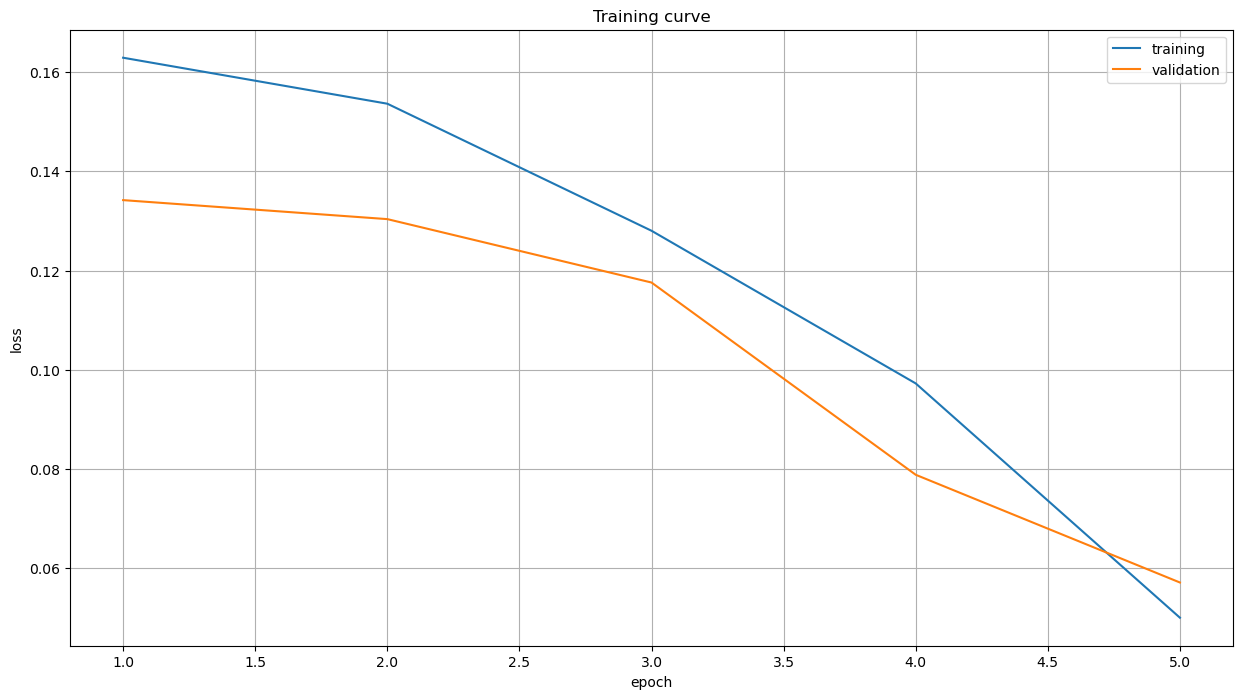

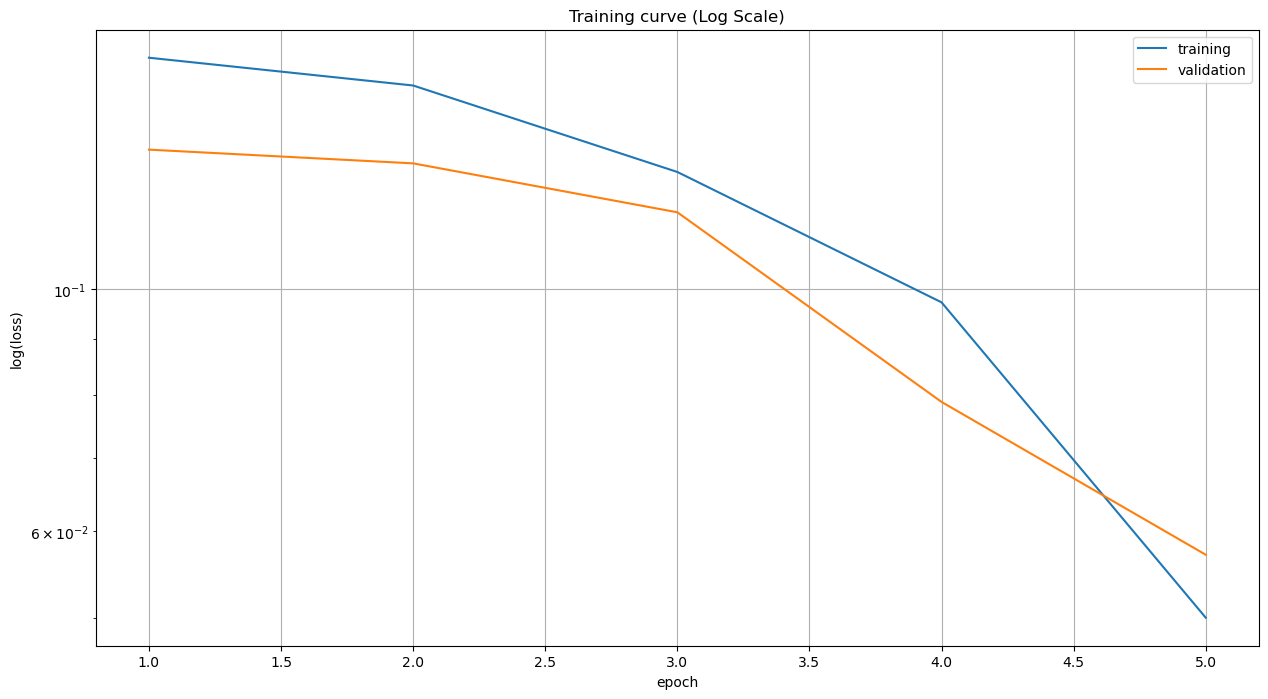

TOTAL TIME = 0.020 hours
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/loss.png
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/val_loss.npy
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/NN_log.txt
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/model


INFO:tensorflow:Assets written to: /tmp/tmp1hebirht/model/assets


INFO:tensorflow:Assets written to: /tmp/tmp1hebirht/model/assets


saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/after_5_epochs/model


In [19]:
if is_notebook:
    print('Notebook mode: running for 5 epochs')
    epochs = 5
    sub_epochs = 1
else:
    print('Script mode: running for 50 epochs')
    epochs = 50
    sub_epochs = 5
N_chunks = int(epochs/sub_epochs)
loss_history = []
val_loss_history = []
verbosity = 1 if is_notebook else 2

# training loop
print('Training for {0} full epochs, and stopping for saving every {1} full epochs, for a total of {2} stages.'.format(epochs,sub_epochs, N_chunks))
start_time = time.time()
for i_chunk in range(N_chunks):
    
    print('-------------------------------------')
    print('epochs {0}-{1}:'.format(i_chunk*sub_epochs+1, (i_chunk+1)*sub_epochs))
    print('-------------------------------------')

    # train
    try:
        # for some reason, the first call to fit will throw KeyError...
        history = siamese_model.fit(train_gen, epochs=sub_epochs, validation_data=val_gen, verbose=verbosity)
    except KeyError:
        history = siamese_model.fit(train_gen, epochs=sub_epochs, validation_data=val_gen, verbose=verbosity)
    loss_history += history.history['loss']
    val_loss_history += history.history['val_loss']
    
    # create the figures for the loss
    loss_fig, loss_ax = plt.subplots(figsize=(15,8))
    loss_ax.set_title('Training curve')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.grid()
    log_loss_fig, log_loss_ax = plt.subplots(figsize=(15,8))
    log_loss_ax.set_title('Training curve (Log Scale)')
    log_loss_ax.set_xlabel('epoch')
    log_loss_ax.set_ylabel('log(loss)')
    log_loss_ax.grid()
    log_loss_ax.set_yscale('log')
    
    # plot the loss
    curr_epochs = (i_chunk+1)*sub_epochs
    e = np.arange(curr_epochs)+1
    plot_loss(loss_fig, loss_ax, e, loss_history, val_loss_history)
    plot_loss(log_loss_fig, log_loss_ax, e, loss_history, val_loss_history)
    plt.show()
    time.sleep(1)
    
    end_time = time.time()
    time_str = 'TOTAL TIME = {0:.3f} hours'.format((end_time - start_time)/3600)
    print(time_str)
    
    # create a sub dir
    s3_save_NN_dir_path_sub_epoch = os.path.join(s3_model_train_dir_path, 'after_{0}_epochs'.format((i_chunk+1)*sub_epochs))
    # save the figures
    to_s3_fig(loss_fig, s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'loss.png'))
    to_s3_fig(log_loss_fig, s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'loss.png'))
    # save the losses
    to_s3_npy(np.array(loss_history), s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'loss.npy'))
    to_s3_npy(np.array(val_loss_history), s3_client, bucket_name, os.path.join(s3_save_NN_dir_path_sub_epoch, 'val_loss.npy'))
    # get model summary
    stringlist = []
    encoding.summary(print_fn=lambda x: stringlist.append(x))
    encoding_summary = "\n".join(stringlist)
    stringlist = []
    siamese_network.summary(print_fn=lambda x: stringlist.append(x))
    siamese_network_summary = "\n".join(stringlist)
    # save log
    log_s3(s3_client, bucket_name, s3_model_train_dir_path, 'NN_log.txt',
        dist_mat_path = dist_mat_path,
        s3_model_train_dir_path = s3_model_train_dir_path,
        training_duration = time_str,
        encoding_summary = encoding_summary,
        siamese_network_summary = siamese_network_summary
        )
    # save the network
    s3_model_path = os.path.join(s3_save_NN_dir_path_sub_epoch, 'model')
    s3_save_TF_model(siamese_model, s3_client, bucket_name, s3_model_path)

# Inference

In [20]:
def infer_dist_mat(model, X, verbosity):
    # predict
    data_gen = DistillationDataGenerator(X, np.zeros(shape=(X.shape[0], X.shape[0])), batch_size=128, shuffle=False, seed=seed, full_epoch=True, norm=True)
    Z_NN = model.predict(data_gen, verbose=verbosity)
    # create full distance matrix
    N = int((-1+np.sqrt(1+8*len(Z_NN)))/2)
    D_NN = np.zeros(shape=(N,N))
    D_NN[np.triu_indices(N)] = Z_NN
    D_NN = D_NN.T
    D_NN[np.triu_indices(N)] = Z_NN
    return D_NN

## Training set

In [23]:
dist_mat = infer_dist_mat(siamese_model, X_train, verbosity)
to_s3_npy(dist_mat, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'dist_mat.npy'))

DataGenerator initialized with:
    X shape = 100x8400
    D shape = 100x100
    batch_size = 128
    shuffle = False
    full_epoch = True
    norm = True
    noise = False
40/40 [==============================] - 15s 385ms/step
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/dist_mat.npy


True

In [24]:
weird_scores = np.mean(dist_mat, axis=1)
to_s3_npy(weird_scores, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'weird_scores.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/weird_scores.npy


True

In [25]:
from sklearn.manifold import TSNE
sne = TSNE(n_components=2, perplexity=25, metric='precomputed', verbose=1, random_state=seed).fit_transform(dist_mat)
to_s3_npy(sne, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'tsne.npy'))

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.065848
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.272308
[t-SNE] KL divergence after 1000 iterations: 0.128307
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/tsne.npy


True

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/weirdness_scores_histogram.png


True

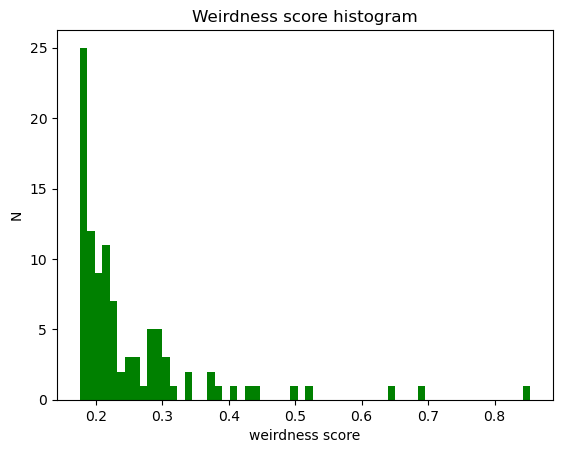

In [26]:
fig = plt.figure()
tmp = plt.hist(weird_scores, bins=60, color="g")
plt.title("Weirdness score histogram")
plt.ylabel("N")
plt.xlabel("weirdness score")
to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'weirdness_scores_histogram.png'))

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/distances_histogram.png


True

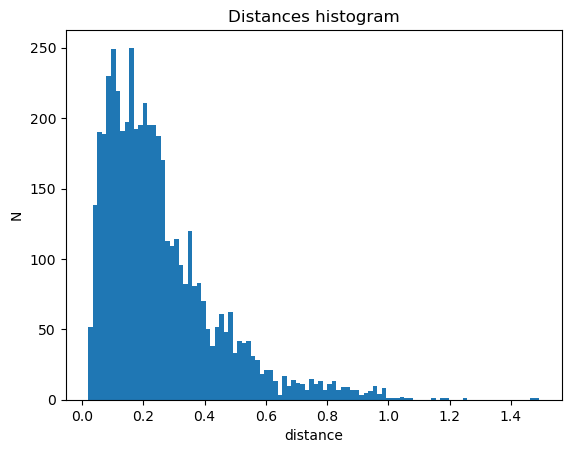

In [27]:
distances = dist_mat[np.tril_indices(dist_mat.shape[0], -1)]

fig = plt.figure()
tmp = plt.hist(distances, bins=100)
plt.title("Distances histogram")
plt.ylabel("N")
plt.xlabel("distance")

to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'distances_histogram.png'))

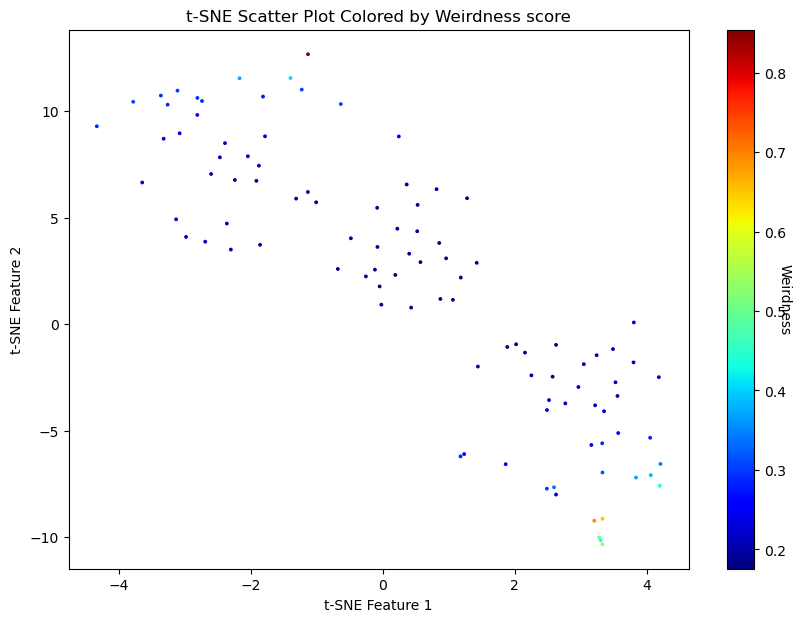

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/tsne_colored_by_weirdness.png


True

In [28]:
sne_f1 = sne[:, 0]
sne_f2 = sne[:, 1]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
im_scat = ax.scatter(sne_f1, sne_f2, s=3, c=weird_scores, cmap=plt.cm.get_cmap('jet'), picker=1)
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r't-SNE Scatter Plot Colored by Weirdness score')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('Weirdness', rotation=270)
plt.show()

to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'tsne_colored_by_weirdness.png'))

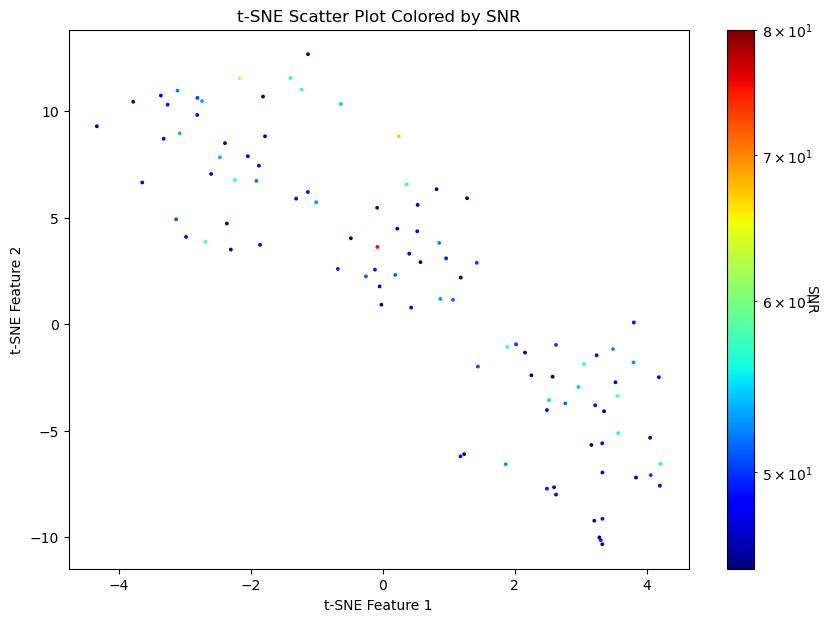

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/train/tsne_colored_by_snr.png


True

In [29]:
snr = gs_train.snMedian

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
import matplotlib.colors as colors
im_scat = ax.scatter(sne_f1, sne_f2, s=3, c=snr, cmap=plt.cm.get_cmap('jet'), norm=colors.LogNorm(vmin=snr.min(), vmax=80))
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r't-SNE Scatter Plot Colored by SNR')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('SNR', rotation=270)
plt.show()

to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_train_dir_path, 'tsne_colored_by_snr.png'))

## Test set

In [30]:
dist_mat_test = infer_dist_mat(siamese_model, X_test, verbosity)
to_s3_npy(dist_mat_test, s3_client, bucket_name, os.path.join(s3_model_test_dir_path, 'dist_mat.npy'))

DataGenerator initialized with:
    X shape = 100x8400
    D shape = 100x100
    batch_size = 128
    shuffle = False
    full_epoch = True
    norm = True
    noise = False
40/40 [==============================] - 15s 386ms/step
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/test/dist_mat.npy


True

In [31]:
weird_scores_test = np.mean(dist_mat_test, axis=1)
to_s3_npy(weird_scores_test, s3_client, bucket_name, os.path.join(s3_model_test_dir_path, 'weird_scores.npy'))

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/test/weird_scores.npy


True

In [32]:
from sklearn.manifold import TSNE
sne_test = TSNE(n_components=2, perplexity=25, metric='precomputed', verbose=1, random_state=seed).fit_transform(dist_mat_test)
to_s3_npy(sne_test, s3_client, bucket_name, os.path.join(s3_model_test_dir_path, 'tsne.npy'))

/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 0.082538
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.412254
[t-SNE] KL divergence after 1000 iterations: 0.375818
saving to uri: s3://tau-astro/almogh/thesis2/models/NN/test/tsne.npy


True

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/test/weirdness_scores_histogram.png


True

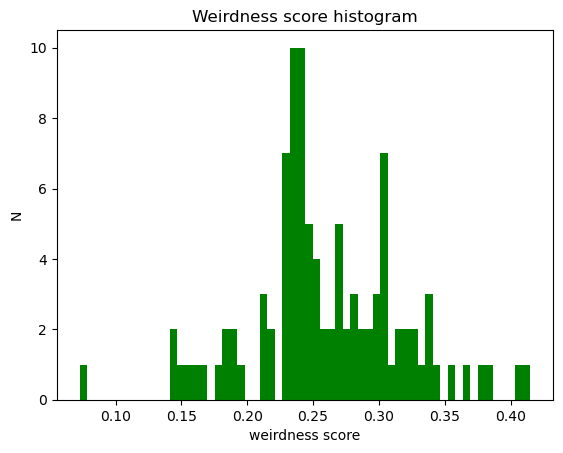

In [33]:
fig = plt.figure()
tmp = plt.hist(weird_scores_test, bins=60, color="g")
plt.title("Weirdness score histogram")
plt.ylabel("N")
plt.xlabel("weirdness score")
to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_test_dir_path, 'weirdness_scores_histogram.png'))

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/test/distances_histogram.png


True

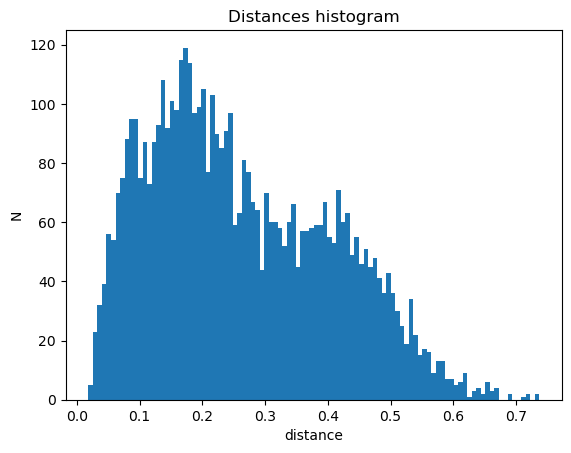

In [34]:
distances_test = dist_mat_test[np.tril_indices(dist_mat_test.shape[0], -1)]

fig = plt.figure()
tmp = plt.hist(distances_test, bins=100)
plt.title("Distances histogram")
plt.ylabel("N")
plt.xlabel("distance")

to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_test_dir_path, 'distances_histogram.png'))

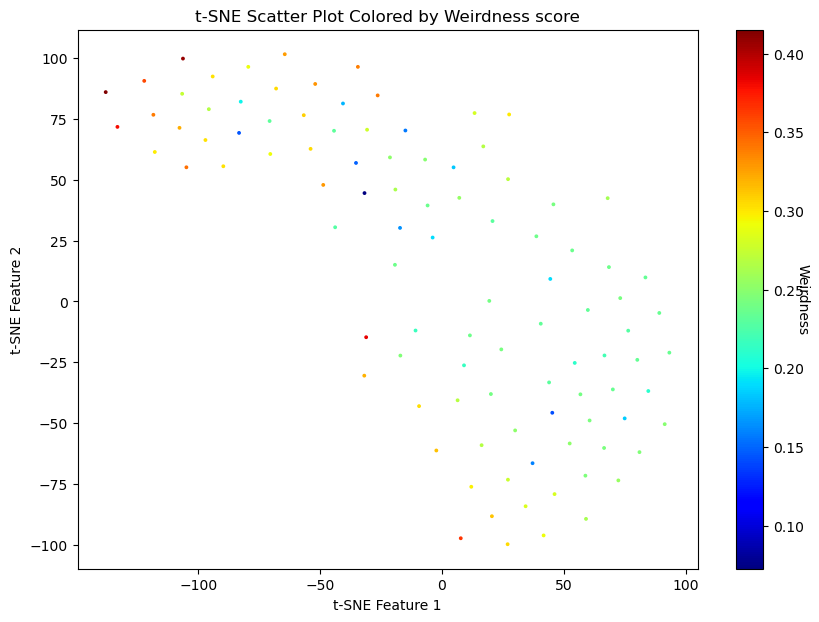

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/test/tsne_colored_by_weirdness.png


True

In [35]:
sne_f1_test = sne_test[:, 0]
sne_f2_test = sne_test[:, 1]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
im_scat = ax.scatter(sne_f1_test, sne_f2_test, s=3, c=weird_scores_test, cmap=plt.cm.get_cmap('jet'), picker=1)
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r't-SNE Scatter Plot Colored by Weirdness score')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('Weirdness', rotation=270)
plt.show()

to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_test_dir_path, 'tsne_colored_by_weirdness.png'))

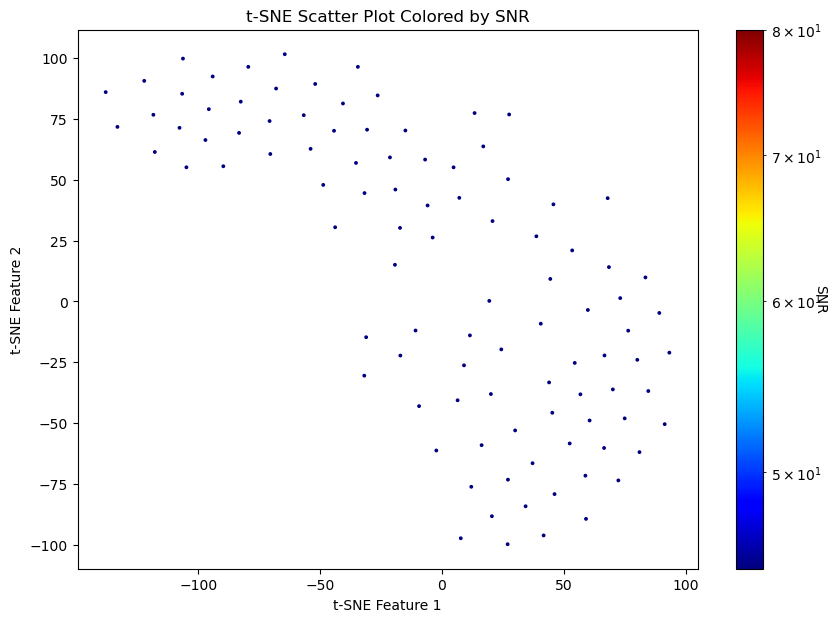

saving to uri: s3://tau-astro/almogh/thesis2/models/NN/test/tsne_colored_by_snr.png


True

In [36]:
snr_test = gs_test.snMedian

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
import matplotlib.colors as colors
im_scat = ax.scatter(sne_f1_test, sne_f2_test, s=3, c=snr_test, cmap=plt.cm.get_cmap('jet'), norm=colors.LogNorm(vmin=snr.min(), vmax=80))
ax.set_xlabel('t-SNE Feature 1')
ax.set_ylabel('t-SNE Feature 2')
ax.set_title(r't-SNE Scatter Plot Colored by SNR')
clb = fig.colorbar(im_scat, ax=ax)
clb.ax.set_ylabel('SNR', rotation=270)
plt.show()

to_s3_fig(fig, s3_client, bucket_name, os.path.join(s3_model_test_dir_path, 'tsne_colored_by_snr.png'))